This code aims to increase the accuracy score on the nueral network provided on the pytorch website without increasing model complexity


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader as dl
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split as rs

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda:0


In [3]:
train_transform = transforms.Compose(
    [
     #transforms.Grayscale(1),
     #transforms.RandomResizedCrop((32,32)),
     transforms.RandomHorizontalFlip(p=0.2),
     transforms.RandomVerticalFlip(p=0.1),
     transforms.ColorJitter(),
     transforms.RandomPerspective(distortion_scale=0.3,p=0.4),
     #transforms.GaussianBlur((1,1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
     
     ]
)

test_transform = transforms.Compose(
    [
        #transforms.Grayscale(1),

        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    ]   
)
#also removed colour because I don't think it helps in learning the classes
batch_size =512

In [4]:

trainset =torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=test_transform)
amount_of_data = len(testset)

testset,validationset = rs(testset,(int(amount_of_data*0.5),int(amount_of_data*0.5)))
trainloader = dl(trainset,batch_size=batch_size,shuffle=True,num_workers=16)
testloader = dl(testset,batch_size=batch_size,shuffle=False,num_workers=16)
validationloader =dl(validationset,batch_size=batch_size,shuffle=False,num_workers=16)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(len(trainset),len(testset),len(validationset))

50000 5000 5000


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


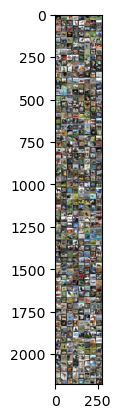

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

#print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
#This net has no dropout

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution1= nn.Conv2d(3,6,5)
        self.pool1 = nn.MaxPool2d(2,2)
        self.convolution2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x = self.pool1(F.relu(self.convolution1(x)))
        x = self.pool1(F.relu(self.convolution2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
#NN with dropout
class ClassifierWithDO(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution1= nn.Conv2d(3,6,5)
        self.pool1 = nn.MaxPool2d(2,2)
        self.do1 = nn.Dropout(.6)
        self.convolution2 = nn.Conv2d(6,40,3)
        self.convolution3 = nn.Conv2d(40,15,3)
        self.fc1 = nn.Linear(15*5*5,1024)
        self.do2 = nn.Dropout(.4)
        self.fc2 = nn.Linear(1024,128)
        self.fc3 = nn.Linear(128,10)
        
    def forward(self,x):
        x = self.pool1(F.relu(self.convolution1(x)))
        x = F.relu(self.convolution2(x))
        x = self.do1(x)
        x =self.pool1(F.relu(self.convolution3(x)))
        x = self.do2(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x= self.do2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
#Initializing the layers

net = Classifier()
net_drop_out= ClassifierWithDO()
print(net_drop_out)
net.to(device)
net_drop_out.to(device)

ClassifierWithDO(
  (convolution1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do1): Dropout(p=0.6, inplace=False)
  (convolution2): Conv2d(6, 40, kernel_size=(3, 3), stride=(1, 1))
  (convolution3): Conv2d(40, 15, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=375, out_features=1024, bias=True)
  (do2): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


ClassifierWithDO(
  (convolution1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do1): Dropout(p=0.6, inplace=False)
  (convolution2): Conv2d(6, 40, kernel_size=(3, 3), stride=(1, 1))
  (convolution3): Conv2d(40, 15, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=375, out_features=1024, bias=True)
  (do2): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
loss_criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
optimizer2 = torch.optim.Adam(net_drop_out.parameters(),lr=0.001)

In [11]:
#Training the model
def model_train(model,epochs,optimization,criteria):
    number_of_epochs = epochs
    average_training_loss_per_epoch = []
    average_validation_loss_per_epoch = []
    epoch_number_tracker =[]
    for epoch in range(number_of_epochs):
        model.train()
        loss_each_epoch = 0
        for rows in trainloader:
            data,label=rows
            data = data.to(device)
            label = label.to(device)
            optimization.zero_grad()
            outputs = model(data)
            loss = criteria(outputs,label)
            loss.backward()
            optimization.step()
            loss_each_epoch += loss.item()
        average_training_loss_per_epoch.append(loss_each_epoch/len(trainloader.dataset))
        epoch_number_tracker.append(epoch+1)
        if ((epoch+1)%10 ==0):
           print(f'epoch: {epoch+1 } is complete')
        model.eval()
        with torch.no_grad():
            validationloss=0
            for row in validationloader:
                image,name=row
                image = image.to(device)
                name = name.to(device)
                guess = model(image)
                valLoss = criteria(guess,name)
                validationloss += valLoss.item()
        average_validation_loss_per_epoch.append(validationloss/len(validationloader.dataset))
    return average_training_loss_per_epoch,average_validation_loss_per_epoch,epoch_number_tracker #might need to return more stuff depending on what else I might need to return more stuff


In [12]:
#training the models
required_epochs = 150

#validation_loss_without_droupout,epochs = model_train(net,required_epochs,optimizer,loss_criteria)
training_loss_with_dropout,validation_loss_with_droupout,unneccessary_epochs = model_train(net_drop_out,required_epochs,optimizer2,loss_criteria)

epoch: 10 is complete
epoch: 20 is complete
epoch: 30 is complete
epoch: 40 is complete
epoch: 50 is complete
epoch: 60 is complete
epoch: 70 is complete
epoch: 80 is complete
epoch: 90 is complete
epoch: 100 is complete
epoch: 110 is complete
epoch: 120 is complete
epoch: 130 is complete
epoch: 140 is complete
epoch: 150 is complete


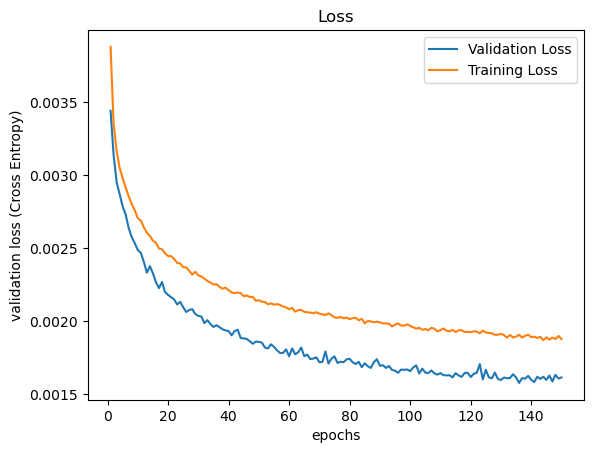

In [13]:
plt.plot(unneccessary_epochs,validation_loss_with_droupout,label='Validation Loss')
plt.plot(unneccessary_epochs,training_loss_with_dropout,label='Training Loss')
plt.xlabel('epochs')
plt.ylabel('validation loss (Cross Entropy)')
plt.title('Loss')
plt.legend()
plt.show()

In [14]:
# plt.plot(epochs,validation_loss_without_droupout,label='Without Dropout')
# plt.xlabel('epochs')
# plt.ylabel('loss/ Cross Entropy')
# plt.legend()
# plt.show()

In [15]:
# plt.plot(epochs,validation_loss_without_droupout,label='Without Dropout')
# plt.plot(unneccessary_epochs,validation_loss_with_droupout,label='With Dropout')
# plt.xlabel('epochs')
# plt.ylabel('loss/ Cross Entropy')
# plt.legend()
# plt.show()

In [16]:
#This is where the test set will come to compare the accuracy of the two models.
def Accuracy_test(testdataloader,model):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testdataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct // total

In [17]:
#without_dropout_accuracy = Accuracy_test(testloader,net)
with_dropout_accuracy = Accuracy_test(testloader,net_drop_out)

#print(f'The NN with no dropout had an accuracy of {without_dropout_accuracy} against an accuracy of {with_dropout_accuracy} for NN with dropout' )

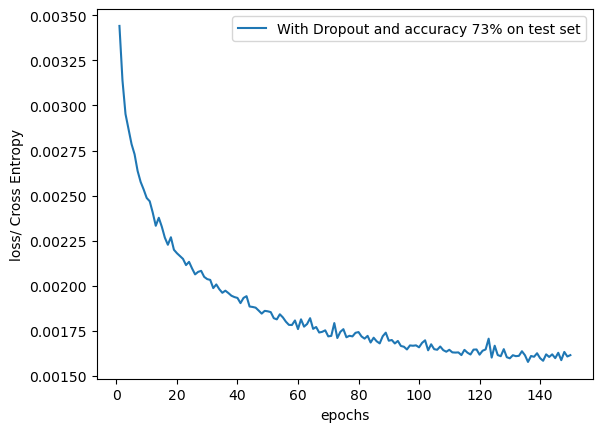

In [18]:
#plt.plot(epochs,validation_loss_without_droupout,label=f'Without Dropout and accuracy {without_dropout_accuracy} on test set')
plt.plot(unneccessary_epochs,validation_loss_with_droupout,label=f'With Dropout and accuracy {with_dropout_accuracy}% on test set')
#plt.ylim(min(validation_loss_without_droupout)-.1,max(validation_loss_with_droupout)+.1)
plt.xlabel('epochs')
plt.ylabel('loss/ Cross Entropy')
plt.legend()
plt.show()

Accuracy of the model has been increased by ~ 20% through augmentation and dropout. Further increase would require increasing model complexity

In [19]:

# PATH = '.NN_without_drop_out.pth'
# torch.save(net_.state_dict(),PATH)

In [20]:
#printing number of trainable parameters
model_parameters = filter(lambda p: p.requires_grad, net_drop_out.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print(f'model has {params} trainable parameters')

model has 525585 trainable parameters
